<a href="https://colab.research.google.com/github/adifatol/BIQA/blob/master/exercise-p100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Copy this Notebook to always get a Colab Notebook with a Tesla P100 GPU and 25GB of RAM 

# Credits to 0x00groot for finding this
https://www.reddit.com/r/MachineLearning/comments/m73sy7/p_my_side_project_cloud_gpus_for_13_the_cost_of/gratmkg?utm_source=share&utm_medium=web2x&context=3

# Link to original notebook
https://colab.research.google.com/drive/1D6krVG0PPJR2Je9g5eN_2h6JP73_NUXz#scrollTo=W3a4PwlSfS8b

SyntaxError: ignored

In [10]:
!nvidia-smi

Fri Mar 19 12:26:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!git clone https://github.com/adifatol/active-learning

Cloning into 'active-learning'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 34 (delta 9), reused 27 (delta 6), pack-reused 0
Unpacking objects: 100% (34/34), done.


In [7]:
import os
os.chdir('/content/active-learning')

In [8]:
!pip install -r requirements.txt

     |████████████████████████████████| 8.3MB 8.8MB/s 
     |████████████████████████████████| 430kB 53.1MB/s 
     |████████████████████████████████| 245kB 57.8MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 71kB 10.2MB/s 
     |████████████████████████████████| 122kB 64.4MB/s 
     |████████████████████████████████| 61kB 8.8MB/s 
ERROR: google-colab 1.0.0 has requirement tornado~=5.1.0; python_version >= "3.0", but you'll have tornado 6.1 which is incompatible.
  Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1
  Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5
  Found existing installation: jsonschema 2.6.0
    Uninstalling jsonschema-2.6.0:
      Successfully uninstalled jsonschema-2.6.0


# Active Learning Tutorial

Unlabelled data is relatively cheap to produce. For labeling their data, companies hire in-house people or external companies to label their data. The cost of labeling is high even for classification task, but increases rapidly for more sophisticated tasks like bounding box detection and semantic segmentation, as can be seen in the bellow pricing scheme:


| Task                 | Per unit  cost |
| --------------       | -------------- |
| Classification       | \$35           |
| Bounding box         | \$63           |
| Segmentation         | \$870          |
| Rotated bounding box | \$86           |

> Pricing scheme taking from https://cloud.google.com/ai-platform/data-labeling/pricing


Ideally you will used self-supervised and semi-supervised learning techniques to train your model on unlabelled data.

Most often, you have no choice and need to labelled your data. To minimize the cost of labelling, you would want to be able to label only the data that gives you the highest ROI, meaning in our case, the highest accuracy improvement. 

This becomes a chicken and egg problem because
* we want to label only the data that gives us the highest accurcy improvement
* we need to know the label to check the accuracy improvement

Active learning works to solve the problem of selecting the unlabelled data most likely to give the highest accuracy improvement for the model.

In this tutorial we will use the CIFAR-10 dataset for exemplifing different active learning strategies. For the implementation, we will use the PyTorch deep learning framework

We will load the libraries and check if the laptop as a GPU that supports CUDA

In [9]:
from utils import utils

import torch
import torchvision
import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

We will load the entire CIFAR10 dataset and define our data augmentation strategy

In [11]:
common_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

extended_transform = transforms.Compose(
    [transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=extended_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=common_transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


We will use a large batch size to make sure that we will have in a batch at least one sample for each class

In [12]:
batch_size = 128
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Now we will check how the data looks

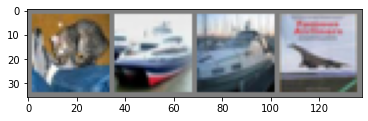

  cat  ship  ship plane


In [13]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

We start of without knowing any labels for our data. We will ask an Oracle to label our data, but this comes with a price. To prevent us going over our labelling budget, the Oracle comes with a budget parameter. This stops any labelling after we reach the budget. After we begin labelling our data, the Oracle can be used like any other PyTorch Dataset.

Because we need to validate our model, the traiset will always be fully labelled.

In [14]:
from utils.oracle import Oracle

budget = 5000 # maximum number of data we can label
print(f"We have a buget for {budget} labelled data, which coresponds to {budget/len(trainset) * 100}% of the total data")
oracle = Oracle(trainset, budget=budget)

We have a buget for 5000 labelled data, which coresponds to 10.0% of the total data


# Random selection as active learning strategy

A dummy active learning strategy would be to randomly select the data to label.

---



In [15]:
import random

data_to_label = random.sample(range(oracle.get_total_data_num()), budget)
oracle.label(data_to_label)

print(f"We have {oracle.get_labelled_data_num()} labelled data")

We have 5000 labelled data


Let's check what accuracy we get by training the model using this strategy

In [16]:
from models.net import Net
import torch.optim as optim
import torch.nn as nn

trainloader = torch.utils.data.DataLoader(oracle, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

net = Net().to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD (net.parameters (), lr = 0.05, momentum = 0.9, weight_decay = 5e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 80], gamma=0.1) 

In [17]:
utils.train(net, trainloader, optimizer, loss_function, scheduler, device, epochs=100, 
                testloader=testloader)

epoch: 100, train loss: 0.0902 test acc 72.84%: 100%|██████████| 100/100 [08:23<00:00,  5.04s/it]


bold text# Entropy based selection as active learning strategy

## Shannon Entropy

We will use Shannon entropy formula to calculate a score for how uncertain the 

---

model is regarding its prediction

$H=-\sum_{i=1}^{M} P_i\,log_2\,P_i $

In [26]:
def entropy(prob_distrib):
    return -torch.sum(prob_distrib*torch.log2(prob_distrib))

Let's check the formula result on a few examples

If the class probability ditribution is uniform, meaning the model is uncertain, the entropy is large

In [27]:
print(entropy(torch.tensor([0.25, 0.25, 0.25, 0.25])))

tensor(2.)


If the model is certain regarding the class, the entropy will be close to 0

In [20]:
print(entropy(torch.tensor([0.997, 0.001, 0.001, 0.001])))

tensor(0.0342)


Now a more realistic class probability distribution for which the entropy is between 0 and entroy of the random case

In [21]:
print(entropy(torch.tensor([0.1, 0.2, 0.15, 0.55])))

tensor(1.6815)


## Train on an small set of the data

First make sure the Oracle is reseted

In [22]:
oracle = Oracle(trainset, budget=budget)

We start of with randomly labelling the data, but only using half of our budget.

In [23]:
import random

data_to_label = random.sample(range(oracle.get_total_data_num()), budget//2)
oracle.label(data_to_label)

print(f"We have {oracle.get_labelled_data_num()} labelled data")

We have 2500 labelled data


We need to create a fresh model and dataloader to make sure we are not affected by the previous experiment.

In [24]:
from models.net import Net
import torch.optim as optim
import torch.nn as nn

trainloader = torch.utils.data.DataLoader(oracle, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

net = Net().to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD (net.parameters (), lr = 0.05, momentum = 0.9, weight_decay = 5e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 80], gamma=0.1) 

In [25]:
utils.train(net, trainloader, optimizer, loss_function, scheduler, device, epochs=100, 
                testloader=testloader)

epoch: 100, train loss: 0.0260 test acc 67.17%: 100%|██████████| 100/100 [05:57<00:00,  3.58s/it]


## Score each image based on the confidence of the model

Define the scoring function

In [28]:
def calc_score(prob_distrib):
    return entropy(prob_distrib)

Calculate the score for each image

In [29]:
from tqdm import tqdm

scoring = []
with torch.no_grad():
    net.eval()
    for idx in tqdm(range(oracle.get_total_data_num())):
        image = oracle.get_image(idx).cuda()
        class_logits = net(torch.unsqueeze(image, 0))
        class_probability_distribution = torch.softmax(torch.sigmoid(class_logits), dim=-1)
        scoring.append((calc_score(class_probability_distribution).cpu(), idx))

100%|██████████| 50000/50000 [04:57<00:00, 168.08it/s]


Select the rest of data that needs labelling based on the score

In [30]:
import heapq
hard_samples = heapq.nlargest(budget, scoring, key=lambda x: x[0])
data_to_label = [idx for score, idx in hard_samples]

Request the oracle to label the data

In [31]:
oracle.label(data_to_label)
print(f"We have now {len(oracle)} labelled data")

We have now 5000 labelled data


We will start a fresh train

In [32]:
from models.net import Net
import torch.optim as optim
import torch.nn as nn

trainloader = torch.utils.data.DataLoader(oracle, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

net = Net().to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD (net.parameters (), lr = 0.05, momentum = 0.9, weight_decay = 5e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 80], gamma=0.1) 

In [33]:
from utils import utils

utils.train(net, trainloader, optimizer, loss_function, scheduler, device, epochs=100, 
                testloader=testloader)

epoch: 100, train loss: 0.1298 test acc 69.34%: 100%|██████████| 100/100 [08:19<00:00,  5.00s/it]


## Iterative selection

In [ ]:
oracle = Oracle(trainset, budget=budget)
num_data_to_label_per_it = budget//10
data_to_label = random.sample(range(oracle.get_total_data_num()), num_data_to_label_per_it)
oracle.label(data_to_label)

i = 0
while oracle.get_labelled_data_num() < budget:
    print(f"We have {oracle.get_labelled_data_num()} labelled data")

    trainloader = torch.utils.data.DataLoader(oracle, batch_size=batch_size,
                                              shuffle=True, num_workers=2)

    net = Net().to(device)

    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.SGD (net.parameters (), lr = 0.05, momentum = 0.9, weight_decay = 5e-3/(i+1))
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 80], gamma=0.1) 

    utils.train(net, trainloader, optimizer, loss_function, scheduler, device, epochs=100, 
                    testloader=testloader)

    scoring = []
    net.eval()
    with torch.no_grad():
        for idx in tqdm(range(oracle.get_total_data_num())):
            image = oracle.get_image(idx).cuda()
            class_logits = net(torch.unsqueeze(image, 0))
            class_probability_distribution = torch.softmax(torch.sigmoid(class_logits), dim=-1)
            scoring.append((calc_score(class_probability_distribution).cpu(), idx))

    hard_samples = heapq.nlargest(num_data_to_label_per_it, scoring, key=lambda x: x[0])
    data_to_label = [idx for score, idx in hard_samples]
    oracle.label(data_to_label)
    i += 1

  0%|          | 0/100 [00:00<?, ?it/s]

We have 500 labelled data


epoch: 71, train loss: 0.0315 test acc 38.49%:  71%|███████   | 71/100 [02:55<01:11,  2.47s/it]

# Train on all data

In [ ]:
from models.net import Net
import torch.optim as optim
import torch.nn as nn

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

net = Net().to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD (net.parameters (), lr = 0.05, momentum = 0.9, weight_decay = 5e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25, 40], gamma=0.1) 

In [ ]:
import os
save_path = './checkpoints/lfull_train.pth'
if os.path.exists(save_path):
    net.load_state_dict(torch.load(save_path))
else:
    utils.train(net, trainloader, optimizer, loss_function, scheduler, device, epochs=50, 
                testloader=testloader)
    torch.save(net.state_dict(), save_path)

epoch: 50, train loss: 0.0131 test acc 92.09%: 100%|██████████| 50/50 [25:23<00:00, 30.47s/it]


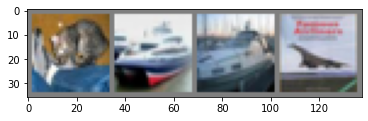

GroundTruth:    cat  ship  ship plane


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane
